In [ ]:
# Comprobación cuda y gpu
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.5.1+cu121
True
1
NVIDIA GeForce RTX 4060


### ENTRENAMIENTO

In [ ]:
from ultralytics import YOLO

# Carga del modelo preentrenado
model = YOLO('yolo11n.pt')

# Entrenamiento para la detección de matrículas
model.train(
    data='dataset/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    device=0
)


Ultralytics 8.3.225  Python-3.9.23 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train10, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016FBCBB4BE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### DETECCIÓN

#### EASYOCR

In [ ]:
import cv2
from ultralytics import YOLO
import pandas as pd
import easyocr

# Modelos YOLO (el general, preentrenado para la detección de vehículos y personas y plates entrenado en la celda anterior para la detección de matrículas)
model_general = YOLO('yolo11n.pt')  # personas y vehículos
model_plates = YOLO(r'runs\detect\train\weights\best.pt')  # matrículas

# EasyOCR con gpu
reader = easyocr.Reader(['es'], gpu=True)

# Clases a detectar por el modelo general
classNames_general = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus",
    "train", "truck"
]
clases_interes = [0, 1, 2, 3, 5, 7]      
clases_matricula = [2, 3, 5, 7]

# Vídeo (recortado para reducir su duración)
video_path = 'C0142-cut.mp4'
vid = cv2.VideoCapture(video_path)

# Procesamiento para un vídeo resultado y un csv con los datos relacionados con las detecciones
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = vid.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter('output_tracking_easyocr.mp4', fourcc, fps, (width, height))

csv_rows = []
frame_num = 0

# Para todos los frames
while True:
    ret, frame = vid.read()
    if not ret:
        break

    annotated_frame = frame.copy()
    frame_num += 1

    # Detección general con GPU
    results_general = model_general.track(
        frame, device='cuda:0', persist=True,
        conf=0.6, iou=0.4, classes=clases_interes, imgsz=960
    )

    for r in results_general:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            cls_name = classNames_general[cls] if cls < len(classNames_general) else str(cls)
            track_id = int(box.id[0]) if box.id is not None else -1
            confidence = round(float(box.conf[0]), 2)

            # Se dibuja una caja para cada detección
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(annotated_frame, f"{cls_name} ID:{track_id} {confidence}", 
                        (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

            # Se pasa el detector de matrículas solo por los vehículos que pueden tener una
            plate_info = {'mx1': None, 'my1': None, 'mx2': None, 'my2': None, 'plate_text': None, 'plate_conf': None}

            if cls in clases_matricula:
                pad = 5
                roi = frame[max(0, y1-pad):y2+pad, max(0, x1-pad):x2+pad]

                if roi.size > 0:
                    results_plate = model_plates.predict(
                        roi, device='cuda:0', conf=0.6, iou=0.4, imgsz=640
                    )

                    for rp in results_plate:
                        for b in rp.boxes:
                            px1, py1, px2, py2 = map(int, b.xyxy[0])
                            px1 += x1; px2 += x1; py1 += y1; py2 += y1
                            plate_conf = round(float(b.conf[0]), 2)

                            # Recorte de la zona donde está la matrícula
                            plate_crop = frame[py1:py2, px1:px2]
                            plate_text = None

                            if plate_crop.size > 0:
                                # Aplicar OCR en dos fases: dígitos y letras por separado
                                ocr_numbers = reader.readtext(plate_crop, allowlist='0123456789')
                                ocr_letters = reader.readtext(plate_crop, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ')

                                # Limpiar y extraer texto OCR
                                num_text = ''.join([r[1] for r in ocr_numbers if r[1].strip().isdigit()]).replace(' ', '').upper()
                                let_text = ''.join([r[1] for r in ocr_letters if r[1].strip().isalpha()]).replace(' ', '').upper()

                                # Limitar formato a 4 números seguidos de letras
                                num_text = ''.join([c for c in num_text if c.isdigit()])[:4]
                                let_text = ''.join([c for c in let_text if c.isalpha()])

                                # Combinar ambas partes si hay texto válido
                                plate_text = num_text + let_text if (num_text or let_text) else None

                            # Dibujar la caja y el texto detectado sobre la matrícula
                            cv2.rectangle(annotated_frame, (px1, py1), (px2, py2), (0,0,255), 2)
                            if plate_text:
                                cv2.putText(annotated_frame, plate_text, (px1, py1-5),
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

                            # Guardar la información de la matrícula detectada
                            plate_info.update({
                                'mx1': px1, 'my1': py1, 'mx2': px2, 'my2': py2,
                                'plate_text': plate_text,
                                'plate_conf': plate_conf
                            })

            # Guardar los datos de cada detección en el registro CSV
            csv_rows.append({
                'frame': frame_num,
                'tipo_objeto': cls_name,
                'confianza': confidence,
                'id_tracking': track_id,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'mx1': plate_info['mx1'], 'my1': plate_info['my1'],
                'mx2': plate_info['mx2'], 'my2': plate_info['my2'],
                'confianza_matricula': plate_info['plate_conf'],
                'texto_matricula': plate_info['plate_text']
            })

    # Mostrar en pantalla el vídeo procesado en tiempo real y guardar cada fotograma en el vídeo resultado
    # cv2.imshow("Detección y OCR", annotated_frame)

    out_vid.write(annotated_frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

vid.release()
out_vid.release()
cv2.destroyAllWindows()

# Crear el CSV final con todas las detecciones
df = pd.DataFrame(csv_rows)
df.to_csv('detecciones_tracking_easyocr.csv', index=False)
print("Vídeo y CSV generados con éxito.")



0: 544x960 1 person, 3 cars, 28.2ms
Speed: 9.2ms preprocess, 28.2ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 960)

0: 512x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 (no detections), 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 (no detections), 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 544x960 1 person, 2 cars, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 960)

0: 512x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 (no detections), 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x960 1 person, 2 cars, 19.2ms
Speed: 4.1ms preprocess, 19.2m

#### SMOLVLM

In [20]:
import cv2
from ultralytics import YOLO
import pandas as pd
import torch
import re
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText


def clean_plate_text(output_text):
    text = output_text  # Corregido: usar output_text en vez de text
    if not text:
        return ""

    # Eliminar etiquetas comunes
    text = re.sub(r"VEHICLELICENSEPLATE|LICENSEPLATE|PLATE|VEHICLE", "", text, flags=re.I)

    # Eliminar etiquetas de chat
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"ASSISTANT:|USER:", "", text, flags=re.I)

    # Solo caracteres alfanuméricos y mayúsculas
    text = re.sub(r"[^A-Z0-9]", "", text.upper())

    return text.strip()

# Configuración del modelo SmolVLM para OCR
Device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧠 Usando dispositivo: {Device}")

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    dtype=torch.bfloat16 if Device == "cuda" else torch.float32,
    _attn_implementation="eager"
).to(Device)


def read_plate_with_smolvlm(plate_crop):
    try:
        # Convertir la imagen a formato PIL para procesarla
        plate_pil = Image.fromarray(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))

        # Preparar el mensaje para el modelo (imagen + texto)
        messages = [{
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "What is the text in this vehicle license plate?"}
            ]
        }]

        # Crear el prompt y procesar entrada
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[plate_pil], return_tensors="pt").to(Device)

        # Generar la salida de texto
        generated_ids = model.generate(**inputs, max_new_tokens=10)
        output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Limpiar texto y devolverlo en formato de matrícula
        text = clean_plate_text(output_text)
        return clean_plate_format(text)

    except Exception as e:
        print(f"⚠️ Error en OCR: {e}")
        return None


def clean_plate_format(text):
    match = re.search(r'(\d{3,4})([A-Z]{2,3})', text)
    if match:
        return match.group(1) + match.group(2)
    return text


# Configuración de los modelos YOLO
model_general = YOLO('yolo11n.pt')  # Detección general (personas, vehículos)
model_plates = YOLO(r'runs\detect\train\weights\best.pt')  # Detección de matrículas

# Clases a detectar por el modelo general
classNames_general = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck"
]
clases_interes = [0, 1, 2, 3, 5, 7]      # personas, bicis, coches, motos, buses, camiones
clases_matricula = [2, 3, 5, 7]          # vehículos susceptibles de tener matrícula


# Configuración del vídeo
video_path = 'C0142-cut.mp4'
vid = cv2.VideoCapture(video_path)

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = vid.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter('output_tracking_smolvlm.mp4', fourcc, fps, (width, height))

csv_rows = []
frame_num = 0


# Para todos los frames
while True:
    ret, frame = vid.read()
    if not ret:
        break

    annotated_frame = frame.copy()
    frame_num += 1

    # Detección de personas y vehículos con YOLO
    results_general = model_general.track(
        frame, device=Device, persist=True,
        conf=0.6, iou=0.4, classes=clases_interes, imgsz=960
    )

    for r in results_general:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            cls_name = classNames_general[cls] if cls < len(classNames_general) else str(cls)
            track_id = int(box.id[0]) if box.id is not None else -1
            confidence = round(float(box.conf[0]), 2)

            # Se dibuja una caja para cada detección
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(annotated_frame, f"{cls_name} ID:{track_id} {confidence}",
                        (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

            # Se pasa el detector de matrículas solo por los vehículos que pueden tener una
            plate_info = {'mx1': None, 'my1': None, 'mx2': None, 'my2': None, 'plate_text': None, 'plate_conf': None}

            # Detección de matrículas dentro del vehículo
            if cls in clases_matricula:
                pad = 5
                roi = frame[max(0, y1-pad):y2+pad, max(0, x1-pad):x2+pad]

                if roi.size > 0:
                    results_plate = model_plates.predict(
                        roi, device=Device, conf=0.6, iou=0.4, imgsz=640
                    )

                    for rp in results_plate:
                        for b in rp.boxes:
                            px1, py1, px2, py2 = map(int, b.xyxy[0])
                            px1 += x1; px2 += x1; py1 += y1; py2 += y1
                            plate_conf = round(float(b.conf[0]), 2)

                            # Recorte de la matrícula detectada
                            plate_crop = frame[py1:py2, px1:px2]
                            plate_text = None

                            # Reconocimiento del texto de la matrícula con SmolVLM
                            if plate_crop.size > 0:
                                plate_text = read_plate_with_smolvlm(plate_crop)

                            # Dibujar la caja y texto OCR sobre la matrícula
                            cv2.rectangle(annotated_frame, (px1, py1), (px2, py2), (0,0,255), 2)
                            if plate_text:
                                cv2.putText(annotated_frame, plate_text, (px1, py1-5),
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

                            # Guardar información de la matrícula
                            plate_info.update({
                                'mx1': px1, 'my1': py1, 'mx2': px2, 'my2': py2,
                                'plate_text': plate_text,
                                'plate_conf': plate_conf
                            })

            # Guardar los datos de cada detección en la lista CSV
            csv_rows.append({
                'frame': frame_num,
                'tipo_objeto': cls_name,
                'confianza': confidence,
                'id_tracking': track_id,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'mx1': plate_info['mx1'], 'my1': plate_info['my1'],
                'mx2': plate_info['mx2'], 'my2': plate_info['my2'],
                'confianza_matricula': plate_info['plate_conf'],
                'texto_matricula': plate_info['plate_text']
            })

    # Mostrar en pantalla el vídeo procesado en tiempo real y guardar cada fotograma en el vídeo resultado
    # cv2.imshow("Detección y OCR (SmolVLM)", annotated_frame)

    out_vid.write(annotated_frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

vid.release()
out_vid.release()
cv2.destroyAllWindows()

# Crear el CSV final con todas las detecciones
df = pd.DataFrame(csv_rows)
df.to_csv('detecciones_tracking_smolvlm.csv', index=False)
print("✅ Vídeo y CSV generados con éxito.")


🧠 Usando dispositivo: cuda

0: 544x960 1 person, 3 cars, 17.8ms
Speed: 15.9ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 960)

0: 512x640 (no detections), 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 (no detections), 9.6ms
Speed: 1.5ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 (no detections), 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)

0: 544x960 1 person, 2 cars, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 960)

0: 512x640 (no detections), 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 (no detections), 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x960 1 person, 2 cars, 20.8ms
Speed: 2

### Comparación de Resultados

EASYOCR.txt: 8552 imágenes, promedio=0.93ms, min=0.40ms, max=17.80ms
SMOLVLM.txt: 8552 imágenes, promedio=0.66ms, min=0.40ms, max=22.40ms


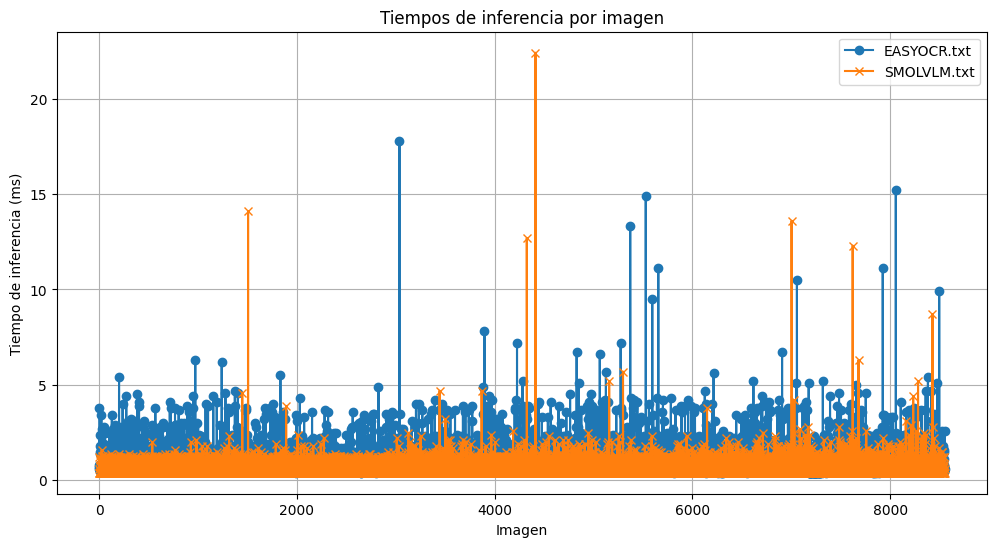

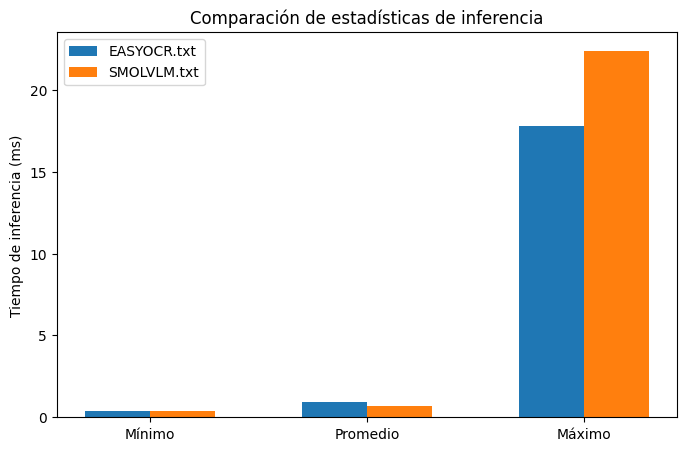

In [ ]:
import re
import matplotlib.pyplot as plt

def extraer_tiempos(archivo_log):
    """Extrae los tiempos de inferencia de un archivo de log."""
    with open(archivo_log, "r", encoding="utf-8") as f:
        log_text = f.read()
    tiempos = re.findall(r'inference, ([\d.]+)ms', log_text)
    return [float(t) for t in tiempos]

def calcular_estadisticas(tiempos):
    """Calcula promedio, mínimo y máximo."""
    if tiempos:
        promedio = sum(tiempos) / len(tiempos)
        minimo = min(tiempos)
        maximo = max(tiempos)
        return promedio, minimo, maximo
    return None, None, None

# Archivos a comparar
archivo1 = "EASYOCR.txt"
archivo2 = "SMOLVLM.txt"

# Extraer tiempos
tiempos1 = extraer_tiempos(archivo1)
tiempos2 = extraer_tiempos(archivo2)

# Calcular estadísticas
prom1, min1, max1 = calcular_estadisticas(tiempos1)
prom2, min2, max2 = calcular_estadisticas(tiempos2)

# Mostrar resultados
print(f"{archivo1}: {len(tiempos1)} imágenes, promedio={prom1:.2f}ms, min={min1:.2f}ms, max={max1:.2f}ms")
print(f"{archivo2}: {len(tiempos2)} imágenes, promedio={prom2:.2f}ms, min={min2:.2f}ms, max={max2:.2f}ms")

# GRÁFICAS

# Gráfica 1: Tiempos de inferencia por imagen
plt.figure(figsize=(12, 6))
plt.plot(tiempos1, label=archivo1, marker='o')
plt.plot(tiempos2, label=archivo2, marker='x')
plt.title("Tiempos de inferencia por imagen")
plt.xlabel("Imagen")
plt.ylabel("Tiempo de inferencia (ms)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfica 2: Comparación de estadísticas (min, promedio, max)
estadisticas = ['Mínimo', 'Promedio', 'Máximo']
valores1 = [min1, prom1, max1]
valores2 = [min2, prom2, max2]

x = range(len(estadisticas))
plt.figure(figsize=(8,5))
plt.bar([i - 0.15 for i in x], valores1, width=0.3, label=archivo1)
plt.bar([i + 0.15 for i in x], valores2, width=0.3, label=archivo2)
plt.xticks(x, estadisticas)
plt.ylabel("Tiempo de inferencia (ms)")
plt.title("Comparación de estadísticas de inferencia")
plt.legend()
plt.show()
